# PRÁCTICA 2: APRENDIZAJE DE PYTORCH

### Javier Izquierdo Hernández
### Alberto León Luengo
### Eva Fernández de la Cruz

---

# Configuración y Visualización del Entorno

## Configuración de las Rutas de Importación

Se añade el directorio padre (..) al path (sys.path), lo que permite al entorno de Python acceder a módulos o paquetes ubicados en directorios superiores al actual. Esto es útil para poder importar scripts o paquetes personalizados sin tener que mover ficheros o el directorio de trabajo.

In [1]:
import sys
sys.path.insert(0, '..')

## Verificación de las Versiones de los Paquetes

Se utiliza la función check_packages() para verificar que los paquetes y sus respectivas versiones indicadas en el diccionario 'd' estén instalados correctamente dentro del entorno. Este paso es importante para verificar la compatibilidad de cada paquete para poder evitar errores por diferencia de versión.

In [2]:
from python_environment_check import check_packages
d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'mlxtend' : '0.19.0',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2',
    'torch': '1.9.0',
    'torchvision': '0.9.0',
    'tensorboard': '2.7.0',
    'pytorch_lightning': '1.5.0',
    'torchmetrics': '0.6.2'
}
check_packages(d)

[OK] Your Python version is 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
[OK] numpy 1.24.3
[OK] scipy 1.8.0
[OK] mlxtend 0.23.1
[OK] matplotlib 3.5.1
[OK] sklearn 1.5.2
[OK] pandas 2.2.2
[OK] torch 2.5.1+cpu
[OK] torchvision 0.20.1+cpu
[OK] tensorboard 2.18.0
[OK] pytorch_lightning 2.4.0
[OK] torchmetrics 1.6.0


## Importación de Paquetes

Se importan los paquetes esenciales para analizar y visualizar datos: numpy para cálculos numéricos, pandas para manipular datos y matplotlib.pyplot para visualizar gráficos, entre otros.

In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

---

# Código Fuente

## Introducción

En este Notebook se abordará el problema de clasificación binaria propuesto en la Práctica 2.

Para ello, se utilizará el dataset 'Adult', obtenido del UC Irvine Machine Learning Repository. Este dataset incluye información sobre las ganancias anuales de una persona, en este caso, la variable de salida 'y' predice si una persona gana más o menos de 50000$ al año, basándose en varias características demográficas y laborales.

Y por último, se hará uso de PyTorch para implementar una red neuronal que satisfaga todo lo mencionado anteriormente. Se ha elegido este dataset ya que contiene todo lo que se nos pide en la Práctica, ya que está compuesto por características categóricas y numéricas.

Para poder utilizar este dataset, se ha utilizado one hot encoding para convertir las características categoricas en números, ya que, debido a errores obtenidos al intentar realizar esto mismo con PyTorch, esta tarea se ha terminado llevando a cabo manualmente con Pandas.

In [4]:
# Obtain the MNIST dataset
header = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

df = pd.read_csv('adult.data', names=header, header=None, sep=', ')
df_test = pd.read_csv('adult.test', names=header, header=None, skiprows=[0], sep=', ')

categorical_columns = df.loc[:, df.dtypes == 'object'].columns
numerical_columns = df.loc[:, df.dtypes == np.int64].columns

# Manual one hot encoding
for cat in categorical_columns:
  indexes = np.unique(df[cat])
  replace = {k: v for v, k in enumerate(indexes)}
  df = df.replace({cat: replace})
  df_test = df_test.replace({cat: replace})

categorical_columns = categorical_columns[:-1]

df.head(1)

/tmp/ipykernel_5988/3248847456.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('adult.data', names=header, header=None, sep=', ')
/tmp/ipykernel_5988/3248847456.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_test = pd.read_csv('adult.test', names=header, header=None, skiprows=[0], sep=', ')
/tmp/ipykernel_5988/3248847456.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_sil

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0


In [5]:
df_test.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,39,0


Como se puede observar, el dataset de training está compuesto por 32561 filas y 15 columnas, mientras que el dataset de test está compuesto por 16281 filas y 15 columnas.

## Conversión del Dataset a PyTorch

Se dividen los datos en training, validation y test para poder realizar el entrenamiento del modelo, quedándonos con un 80% del dataset de entrenamiento para training y el 20% restante para validación. 

Por otro lado, para el dataset de test nos quedamos con todos los datos que nos dan.

In [6]:
df_train, df_valid = train_test_split(
    df, train_size=0.8, random_state=1
)
train_stats = df_train.describe().transpose()

Una vez hecho esto, se normalizan los datos de las columnas numéricas para poder utililzarlos en el entrenamiento de la red neuronal.

In [7]:
df_train_norm, df_valid_norm, df_test_norm = df_train.copy(), df_valid.copy(), df_test.copy()
for col_name in numerical_columns:
    mean = train_stats.loc[col_name, 'mean']
    std  = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:, col_name] = \
        (df_train_norm.loc[:, col_name] - mean)/std
    df_valid_norm.loc[:, col_name] = \
        (df_valid_norm.loc[:, col_name] - mean)/std
    df_test_norm.loc[:, col_name] = \
        (df_test_norm.loc[:, col_name] - mean)/std
df_train_norm.tail()

/tmp/ipykernel_5988/2954724609.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.03136861  1.13088809 -0.48174048 ... -0.84824698  1.49739459
 -0.40843918]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train_norm.loc[:, col_name] = \
/tmp/ipykernel_5988/2954724609.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.71729849 -1.50795867 -0.99484957 ... -0.26183658 -0.62834308
  0.9842855 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_valid_norm.loc[:, col_name] = \
/tmp/ipykernel_5988/2954724609.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.99484957 -0.04193269 -0.77494568 ... -0.04193269  0.39787511
 -0.26183658]' has dtype incompatible with int64, please expli

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
32511,-0.994850,2,3.064737,9,1.128816,4,1,3,2,0,-0.147251,-0.217988,-0.034533,39,0
5192,-0.481740,4,0.166802,9,1.128816,2,4,0,4,1,1.900268,-0.217988,0.370763,39,1
12172,-0.848247,4,-0.807308,9,1.128816,4,7,1,1,1,-0.147251,-0.217988,-0.034533,0,0
235,1.497395,7,0.742826,11,-0.422467,2,8,0,4,1,-0.147251,-0.217988,-0.034533,39,0
29733,-0.408439,4,-1.235551,9,1.128816,2,1,0,4,1,-0.147251,4.493905,0.370763,39,1


Ahora, se dividen los datasets normalizados previamente en X e y para poder entrenar el dataset.

In [8]:
X_train = torch.tensor(df_train_norm[features].values).float()
y_train = torch.tensor(df_train_norm['income'].values).float()
X_valid = torch.tensor(df_valid_norm[features].values).float()
y_valid = torch.tensor(df_valid_norm['income'].values).float()
X_test = torch.tensor(df_test_norm[features].values).float()
y_test = torch.tensor(df_test_norm['income'].values).float()

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

torch.Size([26048, 14])
torch.Size([6513, 14])
torch.Size([16281, 14])


Y por último, se mueven los tensores a la GPU en caso de que ésta se encuentre disponible y se cargan para que puedan ser usados más adelante.

In [9]:
if torch.cuda.is_available():
  X_train = X_train.cuda()
  y_train = y_train.cuda()
  X_valid = X_valid.cuda()
  y_valid = y_valid.cuda()
  X_test = X_test.cuda()
  y_test = y_test.cuda()

train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_ds = TensorDataset(X_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)
test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

## Creación de la Red Neuronal

En primer lugar, se crea una red neuronal simple para clasificación binaria. Para ello, se utiliza ReLU para las activaciones internas y Sigmoid para la salida.

In [10]:
class BinaryClassifier(nn.Module):
    
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

# Model initialization.
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BinaryClassifier(X_train.shape[1]).to(device)
model

BinaryClassifier(
  (layer1): Linear(in_features=14, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Configuración del Entrenamiento de la Red Neuronal

Se define la función de pérdida con BCE (Binary Cross Entropy) y el optimizador, además de configurarse el ciclo de entrenamiento.

In [11]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

## Entrenamiento de la Red Neuronal

Se establecen las épocas (epochs) para ver cómo se va entrenando la red neuronal. En este caso,en vez de entrenarse sólo una vez, se entrena 10 veces, para obtener una mayor y mejor precisión.

Epoch 1, Loss: 0.4378
Epoch 2, Loss: 0.3897
Epoch 3, Loss: 0.3576
Epoch 4, Loss: 0.3398
Epoch 5, Loss: 0.3382
Epoch 6, Loss: 0.3322
Epoch 7, Loss: 0.3314
Epoch 8, Loss: 0.3316
Epoch 9, Loss: 0.3282
Epoch 10, Loss: 0.3261


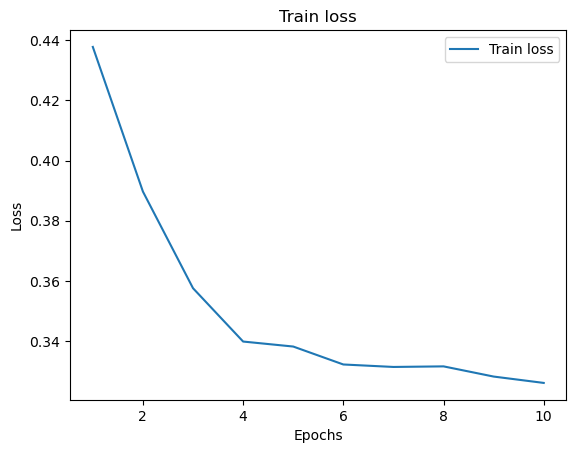

In [12]:
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dl, loss_fn, optimizer)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")

plt.plot(range(1, num_epochs+1), train_losses, label='Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss')
plt.legend()
plt.show()

Como se puede ver, en esta gráfica se puede visualizar la evolución del entrenamiento, el cual es satisfactorio ya que reduce el valor de pérdida casi a 0.

In [13]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch).squeeze()
            predictions = (outputs > 0.5).int()
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

accuracy = evaluate(model, test_dl)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 84.71%


La precisión obtenida se encuentra entre el 80-90%, por lo que se sugiere que el entrenamiento se ha realizado correctamente.

---

# Convertir Jupyter Notebook a Fichero Python

In [14]:
! python .convert_notebook_to_script.py --input notebook.ipynb --output notebook.py

[NbConvertApp] Converting notebook notebook.ipynb to script
[NbConvertApp] Writing 9377 bytes to notebook.py
